# Seminar 1. Introduction to spiking neural networks
## In class:
* Brian2 simulator basics (https://brian2.readthedocs.io): units, neuron group, ODE, plots
* Modeling neurons: spikes and refractoriness
* Leaky integrate and fire
* Input current and spike generators
* Integrate and fire with adaptation
* I-f curve
* Networks in Brian. Synapses
* Connectivity patterns

## Homework
### Excersise 1 (Simple pattern recognition)
Here we model an "artificial retina" which is able to detect orientation of the presented bars. 
The input is a 3x3 matrix I where I(i,j) is the light intensity at the point with coordinates (i,j):

* Create a two-layer network where first layer is "receptor" neurons which transforms the I(i,j) input to the spike frequency. 
* Each neuron of the second layer receives 9 inputs from each "receptor". 
* Each neuron should encode one orientation: vertical, horizontal etc.

### Excercise 2 (Coding by population frequency)
Modify the previous model such that the orientation is encoded by the frequency of total neural activity 

### Excercise 3 (Population coding)



### Brian2 basics
https://brian2.readthedocs.io/en/stable/resources/tutorials/1-intro-to-brian-neurons.html
* Units: volts, seconds, amp etc.
* Equations
* Neuron group
* Monitoring

INFO       No numerical integration method specified for group 'neurongroup_2', using method 'exact' (took 0.04s). [brian2.stateupdaters.base.method_choice]


Before v=-65. mV
After v=-50.000681 mV
Expected value of v = -49.99773 mV


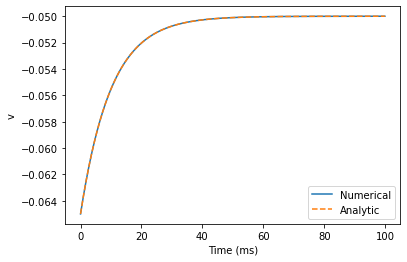

In [7]:
%matplotlib inline
import brian2 as b2
import numpy as np

b2.start_scope() # clear the Brian scope
tau = 10*b2.ms #milliseconds
v_rest = -50 * b2.mvolt #millivolts
v0 = -65 * b2.mvolt
T = 100 * b2.ms
# in ODE line the units must be SI like volts, s, amp
eqs ='''
dv/dt=(v_rest-v)/tau : volt
'''
G = b2.NeuronGroup(1, eqs, method='linear')
G.v = v0
M = b2.StateMonitor(G, 'v', record=True)
print("Before v=%s" % G.v[0])
b2.run(T)
print("After v=%s" % G.v[0])
exp_v = v_rest*(1-b2.exp(-T/tau))
print('Expected value of v = %s' % exp_v)
b2.plot(M.t/b2.ms, M.v[0], label='Numerical')
b2.plot(M.t/b2.ms, v_rest + (v0-v_rest)*b2.exp(-M.t/tau), 'C1--',label='Analytic')
b2.xlabel('Time (ms)')
b2.ylabel('v')
b2.legend();

### Neurons
* input current
* spikes and reset
* refractoriness

https://brian2.readthedocs.io/en/stable/resources/tutorials/1-intro-to-brian-neurons.html#adding-spikes

In [22]:
import matplotlib.pyplot as plt

def plot_v(v_mon, v_threshold = None):
    #plt.subplot(211)
    plt.plot(v_mon.t/b2.ms, v_mon.v[0]/b2.mvolt, label='Membrane voltage')
    plt.xlabel('Time (ms)')
    plt.ylabel('v (mV)')
    if v_threshold:
        plt.axhline(v_threshold/b2.mvolt, ls='--', c='C2', label='threshold') #plot threshold
        
def plot_spikes(s_mon):
    for t in s_mon.t:
        b2.axvline(t/b2.ms, ls='--', c='C1', lw=3)

def plot_I(mon, current):
    plt.xlabel('Time (ms)')
    plt.ylabel('I (nA)')
    plt.plot(mon.t / b2.ms, current(mon.t)/b2.namp, "r", lw=2,
            label='Input current') 
    
def plot_v_spikes(v_mon, s_mon, t_bounds=None):
    b2.figure(figsize=(12,4))
    b2.subplot(121)
    b2.plot(v_mon.t/b2.ms, v_mon.v[0], label='left')
    b2.plot(v_mon.t/b2.ms, v_mon.v[1], label='right')
    if t_bounds:
        b2.xlim(t_bounds)
    b2.xlabel('Time (ms)')
    b2.ylabel('v')
    b2.legend();
    b2.subplot(122)
    b2.plot(s_mon.t/b2.ms,s_mon.i, '.k')
    if t_bounds:
        b2.xlim(t_bounds)
    b2.xlabel('Time (ms)')
    b2.ylabel('Neuron num')     

Spike times: [ 13.8  30.9  48.   65.1  82.2  99.3 116.4 133.5 150.6 167.7 184.8] ms
Frequency: 55. Hz


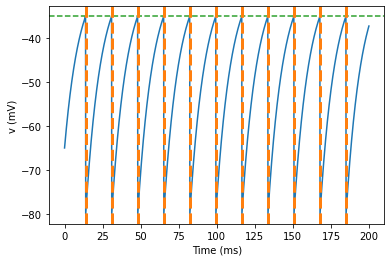

In [37]:
b2.start_scope()
tau = 10*b2.ms #milliseconds
v_rest = -65 * b2.mvolt #millivolts
v0 = -65 * b2.mvolt
v_th = -35 * b2.mvolt
v_reset = -80 * b2.mvolt
R = 10 * b2.Mohm
I = 4 * b2.namp
T = 200 * b2.ms
# in ODE line the units must be SI like volts, s, amp
eqs ='''
dv/dt=(v_rest-v)/tau + R*I/tau: volt
'''
G = b2.NeuronGroup(1,eqs,
                   threshold='v>v_th', 
                   reset='v = v_reset', 
                   method='exact')
G.v = v0
M = b2.StateMonitor(G, 'v', record=True)
spikemon = b2.SpikeMonitor(G)
b2.run(T)
plot_v(M, v_th)
print('Spike times: %s' % spikemon.t[:])
print('Frequency: %s' % str(spikemon.count[0]/T))

plot_spikes(spikemon)

### Refractoriness
After a spike the neuron enters the refractory period and cannot fire new spikes.

Spike times: [  0.  22.  44.  66.  88. 110. 132. 154. 176. 198.] ms
Frequency: 50. Hz


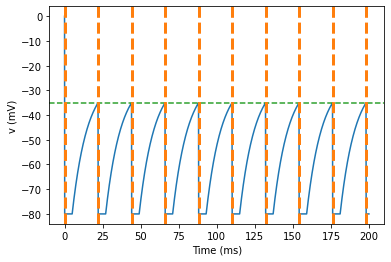

In [38]:
# add refractory period
b2.start_scope()
tau_ref = 5 * b2.ms
eqs ='''
dv/dt=(v_rest-v)/tau + R*I/tau: volt (unless refractory)
'''
G = b2.NeuronGroup(1,eqs,
                   threshold='v>v_th', 
                   reset='v = v_reset',
                   refractory = tau_ref,
                   method='exact')
M = b2.StateMonitor(G, 'v', record=True)
spikemon = b2.SpikeMonitor(G)
b2.run(T)
plot_v(M, v_th)
print('Spike times: %s' % spikemon.t[:])
print('Frequency: %s' % str(spikemon.count[0]/T))
plot_spikes(spikemon)

### Time-dependent input
Here is the example of step current with increasing amplitute

#### Exercise 1
Explore how the spiking frequency of a LIF neuron depends on the amplitude of the step current. 
Plot I-f curve where current is along x-axis and frequency is along y-axis

#### Exercise 2
Implement sinusoidal current and see how the neuron reacts. Print the spiking frequency

Frequncy: 17.5 Hz


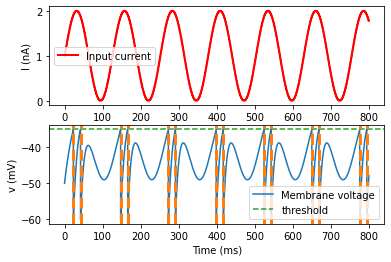

In [9]:
import numpy as np
b2.start_scope()

R = 10. * b2.Mohm # membrane resistance 
tau = 10*b2.ms # membrane time scale
v_rest = -50 * b2.mvolt # rest potential 
v0 = v_rest # initial potential
v_th = -35 * b2.mvolt # threshold
v_reset = -60 * b2.mvolt # reset potential
T = 800 * b2.ms # simulation time
# Create input current
I_subthres = 1.45
I_low = 1.55
I_high = 2.5
#Step input
#I_arr = [0]*5 + [I_subthres]*20 + [I_low]*20 + [I_high]*20 +[0]
#I = b2.TimedArray(I_arr * b2.namp, dt=10 * b2.ms)
#Periodic input
I_arr = 1 + np.sin(1/20*np.arange(T/b2.ms))
I = b2.TimedArray(I_arr * b2.namp, dt=1 * b2.ms)
eqs ='''
dv/dt=(v_rest-v)/tau + R*I(t)/tau : volt
'''
G = b2.NeuronGroup(1,eqs,
                   threshold='v>v_th', 
                   reset='v = v_reset', 
                   method='linear')
G.v = v0
M = b2.StateMonitor(G, 'v', record=True)
spikemon = b2.SpikeMonitor(G)
b2.run(T)

_,(ax_I, ax_V) = plt.subplots(2,1)
plt.subplot(ax_I)
plot_I(M, I)
plt.legend()
plt.subplot(ax_V)
plot_v(M, v_th)
plt.legend()
plot_spikes(spikemon)

### Synapses in Brian2
https://brian2.readthedocs.io/en/stable/resources/tutorials/2-intro-to-brian-synapses.html

WARNING    "tau" is an internal variable of group "neurongroup_5", but also exists in the run namespace with the value 10. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "I" is an internal variable of group "neurongroup_5", but also exists in the run namespace with the value 1.1 * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


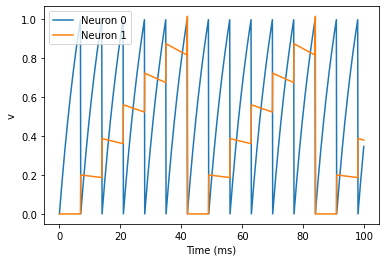

In [31]:
b2.start_scope() # clear the Brian scope

eqs = '''
dv/dt = (I-v)/tau : 1
I : 1
tau : second
'''
G = b2.NeuronGroup(2, eqs, threshold='v>1', reset='v = 0', method='exact')
G.I = [2, 0]
G.tau = [10, 100]*b2.ms

# Comment these two lines out to see what happens without Synapses
S = b2.Synapses(G, G, on_pre='v_post += 0.2')
S.connect(i=0, j=1)

#S_inh = b2.Synapses(G, G, on_pre='v_post -= 0.3')
#S_inh.connect(i=1, j=0)

M = b2.StateMonitor(G, 'v', record=True)

b2.run(100*b2.ms)

plt.plot(M.t/b2.ms, M.v[0], label='Neuron 0')
plt.plot(M.t/b2.ms, M.v[1], label='Neuron 1')
plt.xlabel('Time (ms)')
plt.ylabel('v')
plt.legend();

### LIF with threshold adaptation
Example from Brian2 tutorials:
https://brian2.readthedocs.io/en/stable/examples/adaptive_threshold.html

New input object: SpikeGenerator

#### Excersise
Plot I-f curve for Adaptive LIF neuron

Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in < 1s


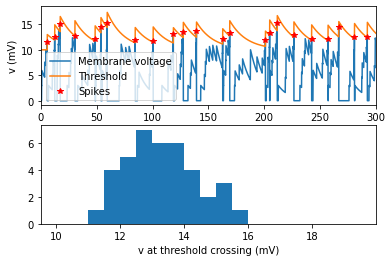

In [10]:
b2.start_scope()
tau_v = 10 * b2.ms
tau_th = 15 * b2.ms
v_reset = 0 * b2.mV
theta = 3 * b2.mV
v_th_0 = 10 * b2.mV
eqs = '''
dv/dt = -v/tau_v : volt
dvt/dt = (v_th_0-vt)/tau_th : volt
'''

reset = '''
v = v_reset
vt += theta
'''

IF = b2.NeuronGroup(1, model=eqs, reset=reset, threshold='v>vt',
                 method='exact')
IF.vt = 10*b2.mV
PG = b2.PoissonGroup(1, 500 * b2.Hz)

w_syn = 3 * b2.mV
C = b2.Synapses(PG, IF, on_pre='v += w_syn')
C.connect()

Mv = b2.StateMonitor(IF, 'v', record=True)
Mvt = b2.StateMonitor(IF, 'vt', record=True)
# Record the value of v when the threshold is crossed
M_crossings = b2.SpikeMonitor(IF, variables='v')
b2.run(0.5*b2.second, report='text')

b2.subplot(2, 1, 1)
b2.plot(Mv.t / b2.ms, Mv[0].v / b2.mV, label='Membrane voltage')
b2.plot(Mvt.t / b2.ms, Mvt[0].vt / b2.mV, label='Threshold')
b2.plot(M_crossings.t/ b2.ms, M_crossings.v / b2.mV, '*r', label='Spikes')
b2.legend()
b2.ylabel('v (mV)')
b2.xlabel('t (ms)')
# zoom in on the first 100ms
b2.xlim(0, 300)
b2.subplot(2, 1, 2)
b2.hist(M_crossings.v / b2.mV, bins=np.arange(10, 20, 0.5))
b2.xlabel('v at threshold crossing (mV)')
b2.show()

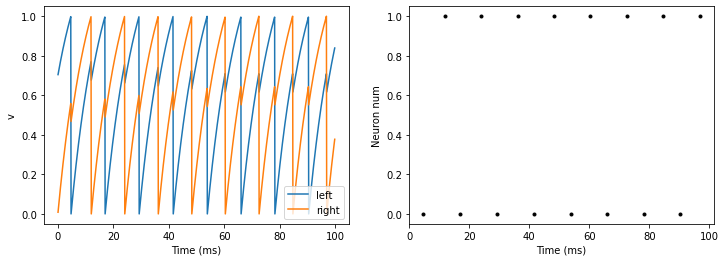

In [44]:
b2.start_scope()
I = 1.5
vt = 1
eqs='''
    dv/dt=(I-v)/tau : 1
    tau : second
    '''
G = b2.NeuronGroup(2, eqs, threshold='v>vt', reset='v = 0', method='linear')
G.tau=[10,10]*b2.ms
G.v='rand()'
w_syn = -0.1
S = b2.Synapses(G, G, on_pre='v += w_syn')
S.connect(i=[0,1], j=[1,0])
#S.connect(i=1,j=0)
v_mon = b2.StateMonitor(G, 'v',record=True)
s_mon = b2.SpikeMonitor(G)
net = b2.Network(G,S,v_mon,s_mon)
net.run(100*b2.ms)
plot_v_spikes(v_mon, s_mon)